In [1]:
%matplotlib inline
import os
import collections
import torch
import torchvision
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt

from SUNRGBDLoader import *

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
import sys, os
import torch
import visdom
import argparse
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torch.autograd import Variable
from torch.utils import data
from tqdm import tqdm

from ptsemseg.models import get_model
from ptsemseg.loader import get_loader, get_data_path
from ptsemseg.metrics import runningScore
from ptsemseg.loss import *
from ptsemseg.augmentations import *


parser = argparse.ArgumentParser(description='Hyperparams')
parser.add_argument('--arch', nargs='?', type=str, default='fcn8s', 
                    help='Architecture to use [\'fcn8s, unet, segnet etc\']')
parser.add_argument('--img_rows', nargs='?', type=int, default=256, 
                    help='Height of the input image')
parser.add_argument('--img_cols', nargs='?', type=int, default=256, 
                    help='Width of the input image')

parser.add_argument('--img_norm', dest='img_norm', action='store_true', 
                    help='Enable input image scales normalization [0, 1] | True by default')
parser.add_argument('--no-img_norm', dest='img_norm', action='store_false', 
                    help='Disable input image scales normalization [0, 1] | True by default')
parser.set_defaults(img_norm=True)

parser.add_argument('--n_epoch', nargs='?', type=int, default=100, 
                    help='# of the epochs')
parser.add_argument('--batch_size', nargs='?', type=int, default=1, 
                    help='Batch Size')
parser.add_argument('--l_rate', nargs='?', type=float, default=1e-5, 
                    help='Learning Rate')
parser.add_argument('--feature_scale', nargs='?', type=int, default=1, 
                    help='Divider for # of features to use')
parser.add_argument('--resume', nargs='?', type=str, default=None,    
                    help='Path to previous saved model to restart from')

parser.add_argument('--visdom', dest='visdom', action='store_true', 
                    help='Enable visualization(s) on visdom | False by default')
parser.add_argument('--no-visdom', dest='visdom', action='store_false', 
                    help='Disable visualization(s) on visdom | False by default')
parser.set_defaults(visdom=False)


In [3]:
args = parser.parse_args('--arch fcn8s_with_rgbd --batch_size 3'.split(' '))

# Setup Augmentations
data_aug= Compose([RandomRotate(10),                                        
                   RandomHorizontallyFlip()])

# Setup Dataloader
data_path = '/home/dongwonshin/Desktop/Datasets/SUNRGBD/SUNRGBD(meta)/'
t_loader = SUNRGBDLoader(data_path, is_transform=True)
v_loader = SUNRGBDLoader(data_path, is_transform=True, split='val')

n_classes = t_loader.n_classes
trainloader = data.DataLoader(t_loader, batch_size=args.batch_size, num_workers=16, shuffle=True)
valloader = data.DataLoader(v_loader, batch_size=args.batch_size, num_workers=16)

# Setup Metrics
running_metrics = runningScore(n_classes)

# Setup visdom for visualization
if args.visdom:
    vis = visdom.Visdom()

    loss_window = vis.line(X=torch.zeros((1,)).cpu(),
                       Y=torch.zeros((1)).cpu(),
                       opts=dict(xlabel='minibatches',
                                 ylabel='Loss',
                                 title='Training Loss',
                                 legend=['Loss']))

# Setup Model
model = get_model(args.arch, n_classes)

model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.cuda()

# Check if model has custom optimizer / loss
if hasattr(model.module, 'optimizer'):
    optimizer = model.module.optimizer
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=args.l_rate, momentum=0.99, weight_decay=5e-4)

if hasattr(model.module, 'loss'):
    print('Using custom loss')
    loss_fn = model.module.loss
else:
    loss_fn = cross_entropy2d

if args.resume is not None:                                         
    if os.path.isfile(args.resume):
        print("Loading model and optimizer from checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        print("Loaded checkpoint '{}' (epoch {})"                    
              .format(args.resume, checkpoint['epoch']))
    else:
        print("No checkpoint found at '{}'".format(args.resume)) 


# Mean and Max

In [4]:
means = []
maxs = []
for i, (color_imgs, depth_imgs, label_imgs) in enumerate(trainloader):
    print(depth_imgs)
#     means.append(np.mean(depth_imgs.numpy()))
#     maxs.append(np.max(depth_imgs.numpy()))
    break


( 0 , 0 ,.,.) = 
  0.1925  0.2043  0.1965  ...  -0.4820 -0.4820 -0.4820
  0.1847  0.1965  0.2043  ...  -0.4859 -0.4859 -0.4820
  0.1847  0.1886  0.2043  ...  -0.4820 -0.4820 -0.4820
           ...             ⋱             ...          
  0.2514  0.2514  0.2514  ...  -0.4624 -0.4624 -0.4663
  0.2514  0.2514  0.2514  ...  -0.4624 -0.4624 -0.4663
  0.2278  0.2514  0.2514  ...  -0.4663 -0.4624 -0.4624
      ⋮  

( 1 , 0 ,.,.) = 
 -0.2388 -0.2388 -0.2388  ...  -0.0035  0.0004  0.0004
 -0.2388 -0.2388 -0.2388  ...   0.0004  0.0004  0.0004
 -0.2388 -0.2388 -0.2349  ...  -0.0035 -0.0035 -0.0035
           ...             ⋱             ...          
 -0.3408 -0.3408 -0.3408  ...  -0.3408 -0.3408 -0.3408
 -0.3408 -0.3408 -0.3408  ...  -0.3408 -0.3408 -0.3408
 -0.3408 -0.3408 -0.3408  ...  -0.3447 -0.3447 -0.3447
      ⋮  

( 2 , 0 ,.,.) = 
 -0.2780 -0.2820 -0.2859  ...  -0.3055 -0.3055 -0.3094
 -0.2820 -0.2859 -0.2859  ...  -0.3016 -0.3055 -0.3016
 -0.2859 -0.2820 -0.2820  ...  -0.3016 -0.3055

In [5]:
means,maxs 

([81.506012], [255.0])

In [5]:
print(np.mean(np.array(means)))
print(np.max(np.array(maxs)))

-0.120735
0.514114


In [10]:
depth_img = m.imread('/home/dongwonshin/Desktop/Datasets/SUNRGBD/SUNRGBD(meta)/test/depth/2.png')
depth_img = np.array(depth_img)
depth_img = m.imresize(depth_img, (480, 640))

In [11]:
depth_img

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [ 0,  0,  0, ..., 61, 61, 61],
       [ 0,  0,  0, ..., 61, 61, 61],
       [ 0,  0,  0, ..., 61, 61, 61]], dtype=uint8)

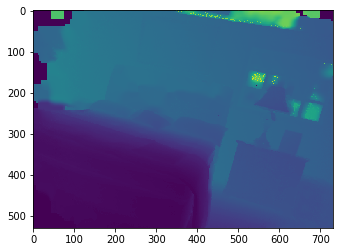

In [8]:
plt.imshow(depth_img)

In [9]:
np.mean(depth_img)

22890.508948048591

## 2018년 05월 08일 23시 00분 56초에 추가



뎁스의 mean값을 빼고 max값으로 나눠서 정규화 해주려했는데..
희한하게..
scipy.io의 imresize함수가..
자동적으로 뎁스영상을 0~255사이의 값으로 바꿔버린다..

imresize가 영상 사이즈 변환하는데 필요한데..
안쓸수는없고..
cv2에도 imresize하는게 있긴한데..
다시 설치하고 하는게 귀찮아서.. 

생각해보니.. scipy의 imresize함수가 자동으로 스케일링 해준다고 생각해버리고..
거기서 평균과 최대값을 구해서 정규화 시켜줬다..

목적은 뎁스 영상의 값 분포가 평균이 0이고 -1~1사이의 값을 가지록 하는게 목적이므로..
일단 이렇게 해주도록 해서 fcn8s_with_rgbd를 다시 학습시켜본다..